In [1]:
import sys
import os.path
import pylab as plt
plt.style.use('dark_background')
#path = '../'
#sys.path.append(path)
from zedstat.zedstat import zedstat
import pandas as pd

In [2]:
df=pd.read_csv('examples_data/roc2.csv')
df=df.sort_values('fpr')
#df=df.drop('threshold',axis=1)

In [3]:
zt=zedstat(df=df,order=3,total_samples=100000,positive_samples=1000,alpha=0.1,prevalence=.01)

In [4]:
zt.smooth(STEP=0.001)
zt.convexify()
zt.allmeasures(interpolate=True)
zt.correctPPV()
zt.usample(precision=3)
zt.cb_delta()
zt.getUL(direction='L')
zt.getUL(direction='U')

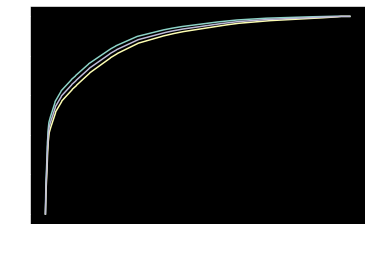

In [5]:
ax=zt.df_lim['U'].tpr.plot()
ax=zt.df_lim['L'].tpr.plot(ax=ax)
ax=zt.get().tpr.plot(ax=ax)


In [6]:
wf=zt.get()

<AxesSubplot:xlabel='LR-'>

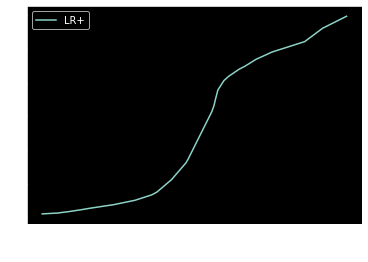

In [7]:
wf.plot(x='LR-',y='LR+')

In [8]:
zt.operating_zone(LRminus=.65)

,fpr,tpr,ppv,acc,npv,LR+,LR-,threshold
high precision,0.008,0.358115,0.307628,0.985499,0.993506,43.99784,0.647145,0.234186
high sensitivity,0.064,0.616202,0.091559,0.932393,0.995877,10.00695,0.409831,0.031257


In [9]:
#IST.auc()
zt.auc_cb2()

In [10]:
zt.auc()

{'L': 0.8738887723569924,
 'U': 0.9011943034492365,
 'nominal': 0.8875903790087464,
 'auc_L': 0.8721951632227701,
 'auc_U': 0.9050772210346357}

In [11]:
zt.interpret(fpr=0.008,number_of_positives=100)

,pos,flags,tp,fp,fn,tn
numbers,100,258,47,211,53,10000


In [12]:
zt.samplesize(delta_auc=.1)

26.99420757849582

<AxesSubplot:>

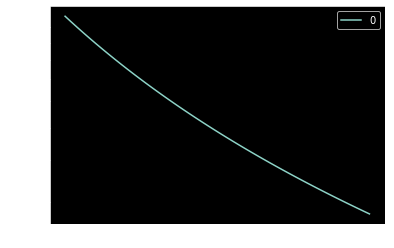

In [13]:
import numpy as np
pd.DataFrame(np.array([zt.samplesize(delta_auc=a) 
                       for a in np.arange(.05,.1,.001)]),
             np.arange(.05,.1,.001)).plot(logy=True)

In [29]:

xf=zt.interpret(fpr=0.008,number_of_positives=100).values[0]
xxf=zt.interpret(fpr=0.008,number_of_positives=100)
xxf

,pos,flags,tp,fp,fn,tn
numbers,100,258,47,211,53,10000


In [46]:
pos=xxf.pos.values[0]
flags=xxf['flags'].values[0]
fp=xxf['fp'].values[0]
tp=xxf['tp'].values[0]
fn=xxf['fn'].values[0]

f"For every {pos} positive instances, we raise {flags} flags, \
out of which {tp} are true positives, {fp} are false alarms, and \
{fn} positive instances are missed"

'For every 100 positive instances, we raise 258 flags, out of which 47 are true positives, 211 are false alarms, and 53 positive instances are missed'

In [25]:
F=1
confusion_matrix=np.array([[xf[2],xf[4]],[F*xf[3],F*xf[5]-F*xf[3]]])
#confusion_matrix=np.array([[xf[2],xf[4]],[F*xf[3],0]])
LG=np.exp(1)
if LG==10:
    confusion_matrix=np.log10(confusion_matrix)
if LG==np.exp(1):
    confusion_matrix=np.log(confusion_matrix)
confusion_matrix

array([[3.8501476 , 3.97029191],
       [5.35185813, 9.18901459]])

In [26]:
from plotly import graph_objects as go

df_ = pd.DataFrame(data=confusion_matrix, 
                  index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                  columns=[f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
df_

,Predicted Class-1,Predicted Class-2
True Class-1,3.850148,3.970292
True Class-2,5.351858,9.189015


In [27]:
df = df_.stack().reset_index()
df.rename(columns={'level_0':'source', 'level_1':'target', 0:'value'}, inplace=True)
# add new column for colour
# here rgba(211,255,216,0.6) indicates green colour whereas rgba(245,173,168,0.6) is red colour
# green colour illustrates correct predictions and red colour is for incorrect predictions
df["colour"] = df.apply(lambda x: 
                          "rgba(211,255,216,0.6)" if x.source.split()[-1] == x.target.split()[-1] 
                           else "rgba(245,173,168,0.6)", axis=1)
# extract unique values from source and target columns
labels = pd.concat([df.source, df.target]).unique()
# get indices of the above unique values
labels_indices = {label:index for index, label in enumerate(labels)}
# map the source and target column using the above indices
df[["source", "target"]] = df[["source", "target"]].applymap(lambda x: labels_indices[x])
df["tooltip"] = df.apply(lambda x:
                         f"{int(np.round(LG**x['value']))} {labels[x['target']].split()[-1]} instances correctly classified as {labels[x['target']].split()[-1]}" 
                         if x['colour']=='rgba(211,255,216,0.6)'
                         
                         else 
                         f"{int(np.round(LG**x['value']))} {labels[x['source']].split()[-1]} instances misclassified as {labels[x['target']].split()[-1]}", axis=1)

num=[int(x.split()[0]) for x in df.tooltip.values]
df['classnums']=[num[0]+num[1],num[2]+num[3],num[0]+num[2],num[1]+num[3]]

In [28]:
from plotly.graph_objs import *
# create a Sankey chart
fig = go.Figure(layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
),
                data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(color = "black", width = 1.0),
      label = labels,
      customdata = df.classnums,
      # this template will be used to display text when hovering over nodes  
      hovertemplate = "%{label} has total %{customdata:d} instances<extra></extra>"
    ),
    link = dict(
      source = df.source, 
      target = df.target,
      value = df.value,
      color = df.colour,
      customdata = df['tooltip'], 
        
      # this template will be used to display text when hovering over the links  
      hovertemplate = "%{customdata}<extra></extra>"  
  ))])

#plt.savefig('sankey.png')
fig.update_layout(font_size=13,
                  width=800, height=600)
fig.show(render="png")
fig.write_image("confusion_matrix.png")


In [19]:
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
